# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [75]:
# import libraries
from pyspark.sql import SparkSession, SQLContext , Window
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, count,sum as Fsum
from pyspark.sql.types import IntegerType
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.feature import StandardScaler,RegexTokenizer, StringIndexer, CountVectorizer, IDF, VectorAssembler, Normalizer
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator , MulticlassClassificationEvaluator
from time import time

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd



In [76]:
# create a Spark session
spark = SparkSession.builder.master("local").appName("Capstone_Project").getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [77]:
# load data into spark DataFrame

mydata = spark.read.json("./mini_sparkify_event_data.json")

mydata.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



## Clean Data

In [78]:
#Clean Dataset

# temp view of the data frame

mydata.createOrReplaceTempView('data_tbl')



In [79]:
# check if there are nulls in sessionId column

spark.sql("""
            SELECT COUNT(userId) as UserId
            FROM data_tbl
            WHERE sessionId IS NULL
        """).show()

+------+
|UserId|
+------+
|     0|
+------+



In [80]:
# check if there are empty sessionIds

spark.sql("""
            SELECT COUNT(userId) as UserId
            FROM data_tbl
            WHERE sessionId == ''
        """).show()

+------+
|UserId|
+------+
|     0|
+------+



In [81]:
# check if there are nulls in userId column

spark.sql("""
            SELECT COUNT(userId) as UserId
            FROM data_tbl
            WHERE userId IS NULL
        """).show()

+------+
|UserId|
+------+
|     0|
+------+



In [82]:
# check if there are empty UserIDs

spark.sql("""
            SELECT COUNT(userId) as UserId
            FROM data_tbl
            WHERE userId == ''
        """).show()

+------+
|UserId|
+------+
|  8346|
+------+



In [83]:
# remove the invalid user IDs from the dataset

mydata = spark.sql("""
                    SELECT *
                    FROM data_tbl
                    WHERE userId != ''
                """)

In [84]:
# temporary view of the data frame

mydata.createOrReplaceTempView('data_tbl')

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.


In [85]:
page = mydata.select("page").dropDuplicates().show()


+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [86]:
# create churn user list

mydata = spark.sql("""
                    SELECT *,
                           CASE
                                WHEN page == 'Cancellation Confirmation' THEN 1
                                ELSE 0 END as Churned
                    FROM data_tbl
                """)

mydata.createOrReplaceTempView('data_tbl')

Churned = spark.sql("""
                            SELECT DISTINCT userID
                            FROM data_tbl
                            WHERE Churned = 1
                        """).toPandas().values

Churned = [user[0] for user in Churned]


In [87]:
#show churned and non-churned user in dataset

spark.sql("""
          SELECT
              Churned,
              count(distinct userId)
            FROM
                data_tbl
            GROUP BY
                Churned
            """)


DataFrame[Churned: int, count(DISTINCT userId): bigint]

In [88]:
#create churn table

churn = spark.sql("""
          SELECT
              distinct userId,
              Churned
            FROM
                data_tbl

            """)
churn.createOrReplaceTempView('churn')


In [89]:
# show  churn in gender

spark.sql("""
          SELECT distinct
              gender,
              Churned,
              count(distinct userId) as DistinctUsers
            FROM
                data_tbl
            GROUP BY
                gender,Churned
            order by Churned desc
            """)

DataFrame[gender: string, Churned: int, DistinctUsers: bigint]

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [90]:
explore_data = mydata.toPandas()

In [125]:
explore_data.drop('Churned',axis='columns', inplace=True)

In [126]:
explore_data.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn
0,Sleeping With Sirens,Logged In,Darianna,F,0,Carpenter,202.97098,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,Captain Tyin Knots VS Mr Walkway (No Way),200,1539003534000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0
1,Francesca Battistelli,Logged In,Darianna,F,1,Carpenter,196.54485,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,Beautiful_ Beautiful (Album),200,1539003736000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0
2,Brutha,Logged In,Darianna,F,2,Carpenter,263.13098,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,She's Gone,200,1539003932000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0
3,None,Logged In,Darianna,F,3,Carpenter,NaN,free,"Bridgeport-Stamford-Norwalk, CT",PUT,Thumbs Up,1538016340000,31,None,307,1539003933000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0
4,Josh Ritter,Logged In,Darianna,F,4,Carpenter,316.23791,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,Folk Bloodbath,200,1539004195000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0


In [127]:
explore_data.describe()

,itemInSession,length,registration,sessionId,status,ts,churn
count,278154.000000,228108.000000,2.781540e+05,278154.000000,278154.000000,2.781540e+05,278154.000000
mean,114.899182,249.117182,1.535359e+12,1042.561624,209.103216,1.540959e+12,0.161292
std,129.851729,99.235179,3.291322e+09,726.501036,30.151389,1.506829e+09,0.367801
min,0.000000,0.783220,1.521381e+12,1.000000,200.000000,1.538352e+12,0.000000
25%,27.000000,199.888530,1.533522e+12,338.000000,200.000000,1.539699e+12,0.000000
50%,70.000000,234.500770,1.536664e+12,1017.000000,200.000000,1.540934e+12,0.000000
75%,157.000000,277.158730,1.537672e+12,1675.000000,200.000000,1.542268e+12,0.000000
max,1321.000000,3024.665670,1.543247e+12,2474.000000,404.000000,1.543799e+12,1.000000


In [128]:
explore_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278154 entries, 0 to 278153
Data columns (total 19 columns):
artist           228108 non-null object
auth             278154 non-null object
firstName        278154 non-null object
gender           278154 non-null object
itemInSession    278154 non-null int64
lastName         278154 non-null object
length           228108 non-null float64
level            278154 non-null object
location         278154 non-null object
method           278154 non-null object
page             278154 non-null object
registration     278154 non-null int64
sessionId        278154 non-null int64
song             228108 non-null object
status           278154 non-null int64
ts               278154 non-null int64
userAgent        278154 non-null object
userId           278154 non-null object
churn            278154 non-null int64
dtypes: float64(1), int64(6), object(12)
memory usage: 40.3+ MB


In [129]:
# from checking if there are empty UserIDs above
# we will drop empty values
explore_data = explore_data.filter(explore_data.userId != '')

In [130]:
cancelation_flag = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

In [131]:
explore_data = mydata.withColumn("churn", cancelation_flag("page"))
window_value = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)

In [132]:
explore_data = explore_data.withColumn("churn", Fsum("churn").over(window_value))

In [133]:
explore_data = explore_data.toPandas()

In [142]:
explore_data.sample(10)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,Churned,churn
187258,The xx,Logged In,Elias,M,30,Love,313.39057,paid,"Salinas, CA",PUT,NextSong,1532696273000,348,Infinity,200,1542409487000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",200025,0,0
52080,None,Logged In,Brayden,M,30,Thomas,NaN,paid,"Los Angeles-Long Beach-Anaheim, CA",GET,Home,1534133898000,734,None,200,1539320124000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",85,0,0
207939,Carl Dobkins_ Jr.,Logged In,Alexander,M,92,Garcia,120.21506,paid,"Indianapolis-Carmel-Anderson, IN",PUT,NextSong,1536817381000,508,My Heart Is An Open Book,200,1539325590000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,105,0,1
270649,None,Logged In,Jayden,M,35,Santos,NaN,free,"Dallas-Fort Worth-Arlington, TX",GET,Help,1533812833000,67,None,200,1539075198000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10)...",100018,0,0
202384,None,Logged In,Micah,M,67,Long,NaN,paid,"Boston-Cambridge-Newton, MA-NH",GET,Settings,1538331630000,2334,None,200,1543319750000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0,0
187651,Lifehouse,Logged In,Andrew,M,161,Poole,259.89179,paid,"Greensboro-High Point, NC",PUT,NextSong,1541223737000,1719,The End Has Only Begun,200,1541744505000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",153,0,0
250710,The Verve,Logged In,Saul,M,4,Johnson,360.25424,paid,"Houston-The Woodlands-Sugar Land, TX",PUT,NextSong,1531804365000,1763,Bitter Sweet Symphony,200,1542011203000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,62,0,0
129529,P!nk,Logged In,Michael,M,270,Miller,227.02975,paid,"Phoenix-Mesa-Scottsdale, AZ",PUT,NextSong,1537014411000,1400,Glitter In The Air,200,1541019841000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.8; r...,60,0,0
17678,Rytmus,Logged In,Sadie,F,217,Jones,254.24934,paid,"Denver-Aurora-Lakewood, CO",PUT,NextSong,1537054553000,2065,Ani jeden skurvy me nezastavi (Explicit),200,1542832017000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",132,0,0
219436,Violadores del Verso,Logged In,Lauren,F,177,Boone,325.72036,paid,"St. Louis, MO-IL",PUT,NextSong,1534859694000,76,Nada mas,200,1539279730000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",300009,0,0


In [135]:

# check churned and non churned users

explore_data.drop_duplicates(subset='userId').groupby(['churn'])['userId'].count()

churn
0    173
1     52
Name: userId, dtype: int64

In [136]:
# Plot function to visualize some Data

def plot(subset, group, labels, x_title="Num. of users", y_title="Sub. Status"):
    
    ax = explore_data.drop_duplicates(subset=subset).groupby(group)['userId'].count().plot(kind='barh',title='Num. of users per category')
    
    ax.set_xlabel(x_title)
    ax.set_yticklabels(labels)
    ax.set_ylabel(y_title)
    

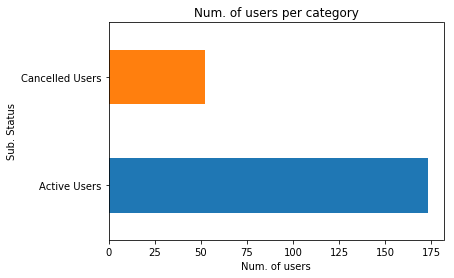

In [137]:
plot(subset = ['userId'], group = ['churn'], labels = ['Active Users', 'Cancelled Users'])

In [138]:
# check churned and non churned users by Gender

explore_data.drop_duplicates(subset='userId').groupby(['gender', 'churn'])['gender'].count()

gender  churn
F       0        84
        1        20
M       0        89
        1        32
Name: gender, dtype: int64

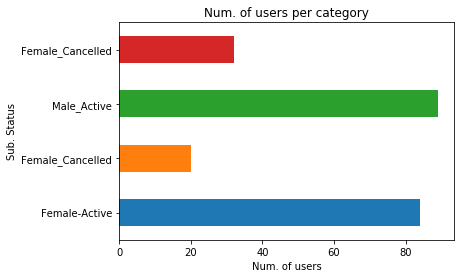

In [139]:
plot(subset=['userId', 'gender'], group = ['gender', 'churn'], labels = ['Female-Active', 'Female_Cancelled', 'Male_Active', 'Female_Cancelled'])

In [140]:
# check churned and non churned users by Payment

explore_data.drop_duplicates(subset='userId').groupby(['level', 'churn'])['level'].count()

level  churn
free   0        133
       1         44
paid   0         40
       1          8
Name: level, dtype: int64

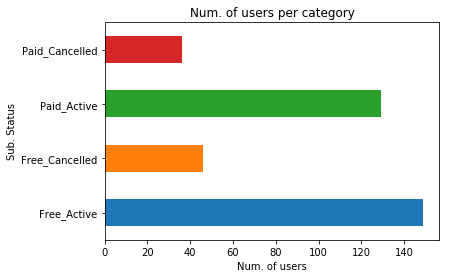

In [141]:
plot(subset=['userId', 'level'], group=['level', 'churn'], labels=['Free_Active', 'Free_Cancelled', 'Paid_Active', 'Paid_Cancelled'])

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [106]:
#gender feature " replace str by int values"


gender = mydata.dropDuplicates(['userId']).sort('userId').select(['userId','gender'])
gender = gender.replace(['F','M'], ['1', '0'], 'gender')
gender = gender.withColumn('gender', gender.gender.cast("int"))

gender.createOrReplaceTempView('gender')

In [107]:
#number of songs played per user 

songs = mydata.where(mydata.song!='null').groupby('userId')
songs= songs.agg(count(mydata.song).alias('Played_Songs')).orderBy('userId')
songs = songs.select(['userId','Played_Songs'])

songs.createOrReplaceTempView('songs')

In [108]:
# number of listened singers per user 

listened_singers_per_user = mydata.dropDuplicates(['userId','artist']).groupby('userId')
listened_singers_per_user = listened_singers_per_user.agg(count(mydata.artist).alias('Listened_Singers')).orderBy('userId')
listened_singers_per_user = listened_singers_per_user.select(['userId','Listened_Singers'])

listened_singers_per_user.createOrReplaceTempView('listened_singers_per_user')

In [109]:
#thumbs_Down

thumbs_Down = mydata.where(mydata.page=='Thumbs Down').groupby(['userId'])
thumbs_Down = thumbs_Down.agg(count(col('page')).alias('thumbs_down')).orderBy('userId')
thumbs_Down = thumbs_Down.select(['userId','thumbs_down'])

thumbs_Down.createOrReplaceTempView('thumbs_Down')

In [110]:
#thumbs_Up

thumbs_Up = mydata.where(mydata.page=='Thumbs Up').groupby(['userId'])
thumbs_Up = thumbs_Up.agg(count(col('page')).alias('thumbs_Up')).orderBy('userId')
thumbs_Up = thumbs_Up.select(['userId','thumbs_Up'])

thumbs_Up.createOrReplaceTempView('thumbs_Up')

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [111]:
# join features

Data = churn.dropDuplicates(['userId']).sort('userId').select(['userId','Churned'])
for selected_features in [ gender, songs, listened_singers_per_user, thumbs_Up, thumbs_Down]:
    Data = Data.join(selected_features,'userId')


In [112]:
# convert data type into float
for selected_features in Data.columns[1:]:
    Data = Data.withColumn(selected_features,Data[selected_features].cast('float'))

In [113]:
Data.dtypes

[('userId', 'string'),
 ('Churned', 'float'),
 ('gender', 'float'),
 ('Played_Songs', 'float'),
 ('Listened_Singers', 'float'),
 ('thumbs_Up', 'float'),
 ('thumbs_down', 'float')]

In [114]:
# split our data into train and test sets

train_set, test_set = Data.randomSplit([0.8, 0.2])

In [115]:
assembler = VectorAssembler(inputCols=Data.columns[2:],outputCol='featuresassemble')
scaler = StandardScaler(inputCol="featuresassemble", outputCol="features")
indexer = StringIndexer(inputCol="Churned", outputCol="label")
stringIndexer = StringIndexer(inputCol="label", outputCol="indexed")
RandomForestClassifier = RandomForestClassifier(numTrees=3, maxDepth=2, labelCol="indexed")
LogisticRegression =  LogisticRegression(maxIter=100, regParam=0.0, elasticNetParam=0)

In [116]:
LogisticRegression_pipeline = Pipeline(stages=[assembler, scaler, indexer, LogisticRegression])

paramGrid_LogisticRegression = ParamGridBuilder().addGrid(LogisticRegression.regParam,[0.0, 0.1, 0.01]).build()

CrossValidator_LogisticRegression = CrossValidator(estimator=LogisticRegression_pipeline,estimatorParamMaps=paramGrid_LogisticRegression,
                                    evaluator=MulticlassClassificationEvaluator(metricName = 'f1'),numFolds=3)

start_time = time()
CrossValidator_LogisticRegression_Model = CrossValidator_LogisticRegression.fit(train_set)
end_time = time()

print('The training process take {} seconds'.format(end_time - start_time))

CrossValidator_LogisticRegression_Model.avgMetrics

The training process take 923.1168491840363 seconds


[0.8297728719764362, 0.8256805908727608, 0.8256805908727608]

In [117]:
RandomForest_pipeline = Pipeline(stages=[assembler, scaler, indexer, stringIndexer, RandomForestClassifier])

paramGrid_RandomForest = ParamGridBuilder().addGrid(RandomForestClassifier.numTrees,[10, 30]).build()

CrossValidator_RandomForest = CrossValidator(estimator=RandomForest_pipeline,estimatorParamMaps=paramGrid_RandomForest,
                              evaluator=MulticlassClassificationEvaluator(metricName = 'f1'),numFolds=3)

start_time = time()
CrossValidator_RandomForest_Model = CrossValidator_RandomForest.fit(train_set)
end_time = time()

print('The training process take {} seconds'.format(end_time - start_time))

CrossValidator_RandomForest_Model.avgMetrics

The training process take 617.9057967662811 seconds


[0.8256805908727608, 0.8256805908727608]

# Performance of models


In [120]:
def performance(model, test_data, metric = 'f1'):
    
    """
    
    this function to Evaluate model performance 
    
        Input: 
            model - trained model
            metric - used metric to evaluate performance
            data - test set that performance measurement should be performed
            
        Output:
            evaluated_score
    """
    
    evaluator = BinaryClassificationEvaluator(metricName = 'areaUnderROC')
    
    predictions = model.transform(test_data)
    
    # evaluated_score
    evaluated_score = evaluator.evaluate(predictions)
    
    return evaluated_score

In [121]:
model_RandomForest_fitted = RandomForest_pipeline.fit(train_set)
model_LogisticRegression_fitted = LogisticRegression_pipeline.fit(train_set)

In [122]:
performance(model_RandomForest_fitted, test_set)

0.49107142857142855

In [123]:
performance(model_LogisticRegression_fitted, test_set)

0.7202380952380952

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.